<a href="https://colab.research.google.com/github/anutitto/dissertation/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=bff3d70ddf10ebdedb4c12e11e8de6aea86e71eca6de56278fdf79712e581897
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [41]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count
spark = SparkSession.builder.appName("fraud_detection_financialtransactions").getOrCreate()
df = spark.read.csv('dataset.csv', header=True, inferSchema=True)
df2 = df.select([count(when(col(c).contains('Unknown') | \
                            col(c).contains('N/A') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in df.columns])
df2.show()


+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [42]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

df_new = df.withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())))
df_new.show()


+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+---+
|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|      V28|Amount|Class| id|
+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+---+
|   0|-1.359807|-0.072781| 2.536347| 1.378155|-0.338321| 0.462388| 0.239599| 0.098698| 0

In [43]:
df_new=df_new.select('id','Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','Amount','Class')
df_new.show()

+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+
| id|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|Amount|Class|
+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+
|  1|   0|-1.359807|-0.072781| 2.536347| 1.378155|-0.338321| 0.462388| 0.239599| 0.098698| 0.363787| 0.090794|  -0.551

In [45]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler().setInputCols\
            (df_new.columns).setOutputCol("features")
transformed = assembler.transform(df_new)
scaler = MinMaxScaler(inputCol="features",\
         outputCol="scaledFeatures")
scalerModel =  scaler.fit(transformed.select("features"))
scaledData = scalerModel.transform(transformed)
scaledData.show()

+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+--------------------+--------------------+
| id|Time|       V1|       V2|       V3|       V4|       V5|       V6|       V7|       V8|       V9|      V10|      V11|      V12|      V13|      V14|      V15|      V16|      V17|      V18|      V19|      V20|      V21|      V22|      V23|      V24|      V25|      V26|      V27|Amount|Class|            features|      scaledFeatures|
+---+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------+-----+--------------------+--------------

In [67]:
def extract(row):
    return tuple(row.scaledFeatures.toArray().tolist())
final_data = scaledData.select("scaledFeatures").rdd\
               .map(extract).toDF(df_new.columns)
final_data.show()
print(final_data.count(),len(final_data.columns))
final_data=final_data.toPandas()

+--------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+--------------------+-----+
|                  id|                Time|                V1|                V2|                V3|                 V4|                V5|                 V6|                 V7|                V8|                 V9|               V10|                V11|               V12|                V13|               V14|                V15|                V16|               V17|               V18|          

In [68]:
import pandas as pd
final_data.to_csv("dataset_final.csv",index=False)

In [77]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE

# define dataset
data_smote=pd.read_csv("dataset_final.csv")
y = data_smote['Class']#dependent variable
X = data_smote.drop(['Class'], axis = 1)#independent variable
smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))
data_smote_new = pd.DataFrame(x_smote, columns=X.columns)
data_smote_new['Class'] = y_smote



Original dataset shape Counter({0.0: 284315, 1.0: 492})
Resample dataset shape Counter({0.0: 284315, 1.0: 284315})


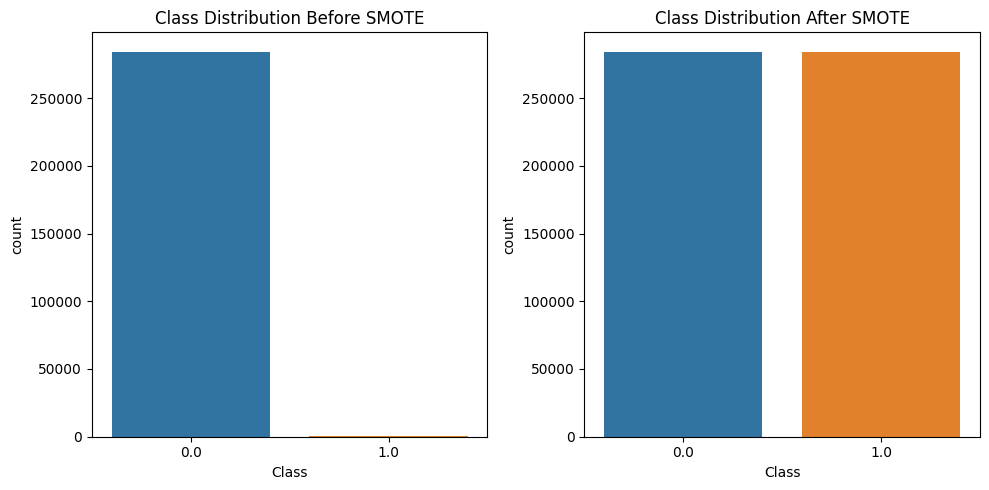

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(121)
g = sns.countplot(x='Class', data=data_smote)
g.set_title('Class Distribution Before SMOTE')

plt.subplot(122)
g_smote = sns.countplot(x='Class', data=data_smote_new)
g_smote.set_title('Class Distribution After SMOTE')

plt.tight_layout()  # To avoid overlapping of subplots
plt.show()